## load data

In [1543]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
# import progressbar
from progressbar import ProgressBar
import time

import torch
from torch import nn
from torch import optim
# from torch.utils.data import DataLoader, Dataset
import torchvision as tv

import csv
import networkx as nx
import os
import glob
from pathlib import Path
import shutil
import datetime

import importlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import add_self_loops, degree, erdos_renyi_graph
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.datasets import TUDataset
from torch.nn import Linear, ReLU
from torch.nn.functional import relu, softmax

import tools_Amedee
importlib.reload(tools_Amedee)         # pour recharger les modifications
from tools_Amedee import *

In [1544]:
# data = pd.read_table('./data/trips_SD_200_steps.csv', sep = ',')
# data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

# # colony = (-77.264, -11.773)
# colony =  (-32.392, -3.819)
# scale = 2e5

# data = format_data(data, colony, scale)
# data = data[data.dist_colony > 1000]

# padding = 200
# traj = padding_data(data, padding)

# print('range : \nmin : ' + str(np.min(traj)) + '\nmax : ' + str(np.max(traj)))



num_nodes = 50
new_size = 50
padding = num_nodes
gan = "AmedeeGAN"

colony = [-17.97, -38.70]   # Abrolhos

sub_set = ""
# sub_set = "BRA_ABR_2019_02/"
# csv_files = glob.glob('Data_segmented_with_dist_reshaped/'+sub_set+str(num_nodes)+'nodes/*.csv')

oiseau = "Dactyl/"
csv_files = glob.glob("../Data_segmented_completed_with_features_reshaped/*/"+str(num_nodes)+"nodes/"+oiseau+"*.csv")
# csv_files = glob.glob("Data_segmented_completed_with_features_reshaped_temps/"+str(num_nodes)+"nodes/"+oiseau+"*.csv")
main_path = gan+'/'+str(num_nodes)+"nodes/all_features/"+oiseau  # utilisé pour sauvegarder les modèles et les graphes générés
# main_path = gan+'/'+str(num_nodes)+"nodes/temp_seg/"+oiseau  # utilisé pour sauvegarder les modèles et les graphes générés

df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

columns = ["lat", "lon"]
# "dist_to_nest", "depth"
# dist_bool = True
df_list = [np.array(df[columns]) for df in df_list]
print(len(df_list))



152


In [1545]:
# class TrajDataSet(Dataset):
#     def __init__(self,  traj, transform=None):
#         self.traj = traj
#         self.transform = transform

#     def __len__(self):
#         return self.traj.shape[0]

#     def __getitem__(self, idx):
#         # select coordinates
#         sample = self.traj[idx,:,:]
#         if self.transform:
#             sample = self.transform(sample)

#         return sample

# class ToTensor(object):
#     """Convert ndarrays in sample to Tensors."""
#     def __call__(self, sample):
#         return torch.FloatTensor(sample)

In [1546]:
all_features = np.concatenate(df_list, axis=0)
print(all_features.shape)
# For data normalization and scaling:
mean = np.mean(all_features, axis=0)
print(mean.shape)
mean = np.array(colony)
print(mean.shape)
std = np.std(all_features, axis=0)

scale = scale = 2e5
batch_size = 25

scaled_graph_list = []
for df in df_list:
    scaled_features = (df - mean) / std
    scaled_features = torch.from_numpy(scaled_features.reshape(2, num_nodes)).float()
    # scaled_features = torch.from_numpy(format_data(df, colony, scale).reshape(2, num_nodes)).float()
    scaled_graph_list.append(scaled_features)

train_set = scaled_graph_list


# train_set = TrajDataSet(traj, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)



(7600, 2)
(2,)
(2,)


In [1547]:
x =  next(iter(train_loader))

In [1548]:
len(train_set)

152

In [1549]:
def periodogram(tt):
  periodogram = torch.mean(torch.fft.fft(tt, 200).abs(), 0)
  return torch.log(periodogram)


## deep networks

Architecture guidelines for stable Deep Convolutional GANs (Radford et al. 2016)

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.



In [1550]:
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [1551]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1552]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [1553]:
def periodogram(tt):
  periodogram = torch.mean(torch.fft.fft(tt, 50).abs(), 0)
  return torch.log(periodogram)

# 2 : DCGAN + conv1D + Fourier regularization

In [1554]:
class CNNGenerator2(nn.Module):
    def __init__(self):
        super().__init__()

        # self.cnn = nn.Sequential(    
        #     nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
        #     nn.BatchNorm1d(128),
        #     nn.ReLU(True),

        #     nn.ConvTranspose1d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(True),

        #     nn.ConvTranspose1d(64, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
        #     nn.BatchNorm1d(32),
        #     nn.ReLU(True),

        #     nn.ConvTranspose1d(32, 16, kernel_size = 4, stride = 2, padding = 1, bias = False),
        #     nn.BatchNorm1d(16),
        #     nn.ReLU(True),

        #     nn.Conv1d(16, 8, kernel_size = 3, stride = 1, padding = 1, bias = False),
        #     nn.ReLU(True),
        #     nn.Conv1d(8, 2, kernel_size = 3, stride = 1, padding = 1, bias = False),
        #     # nn.Tanh()

        #  )

        self.cnn = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=13, stride=5, padding=1, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 64, kernel_size=5, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(True),

            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 16, kernel_size=6, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU(True),

            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv1d(8, 2, kernel_size=3, stride=1, padding=1, bias=False),
            # nn.Tanh()
        )

    def forward(self, z):    
        out = self.cnn(z)

        return out

In [1555]:
z = torch.rand((batch_size, 256, 1), device = device)
gen = CNNGenerator2().to(device)
gen(z).shape

torch.Size([25, 2, 50])

In [1556]:
class CNNDiscriminator2(nn.Module):
    def __init__(self):
        super().__init__()
                
        # self.cnn = nn.Sequential(
            
        #     nn.Conv1d(2, 8, kernel_size = 3, stride = 1, padding = 1, bias = False),
        #     nn.LeakyReLU(0.2, inplace=False),
        #     nn.Conv1d(8, 16, kernel_size = 3, stride = 1, padding = 1, bias = False),
        #     nn.LeakyReLU(0.2, inplace=False),

        #     nn.Conv1d(16, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
        #     nn.BatchNorm1d(32),
        #     nn.LeakyReLU(0.2, inplace=False),

        #     nn.Conv1d(32, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
        #     nn.BatchNorm1d(64),
        #     nn.LeakyReLU(0.2, inplace=False),

        #     nn.Conv1d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
        #     nn.BatchNorm1d(128),
        #     nn.LeakyReLU(0.2, inplace=False),

        #     nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
        #     nn.Sigmoid()
        # )
    
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(64, 128, kernel_size=2, stride=2, padding=0, bias=False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(128, 1, kernel_size=2, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        out = self.cnn(x)
        return out.squeeze(1)

In [1557]:
dis = CNNDiscriminator2().to(device)
dis(x.to(device)).shape

torch.Size([25, 2])

In [1558]:
generator = CNNGenerator2().to(device)
discriminator = CNNDiscriminator2().to(device)

### WEIGHT INITIALIZATION
# generator.apply(weights_init)
# discriminator.apply(weights_init)

generator.load_state_dict(torch.load('results_amedeeGAN/G_SD_2.pt'))
discriminator.load_state_dict(torch.load('results_amedeeGAN/D_SD_2.pt'))

criterion = nn.BCELoss()

lr = 0.0002
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_g = optim.Adam(generator.parameters(),lr= lr, betas=(0.5, 0.999))


Epoch [501/2000] -----------------------------------------------------------------------------
G: 9.01, Dr : 0.43, Df : 0.52


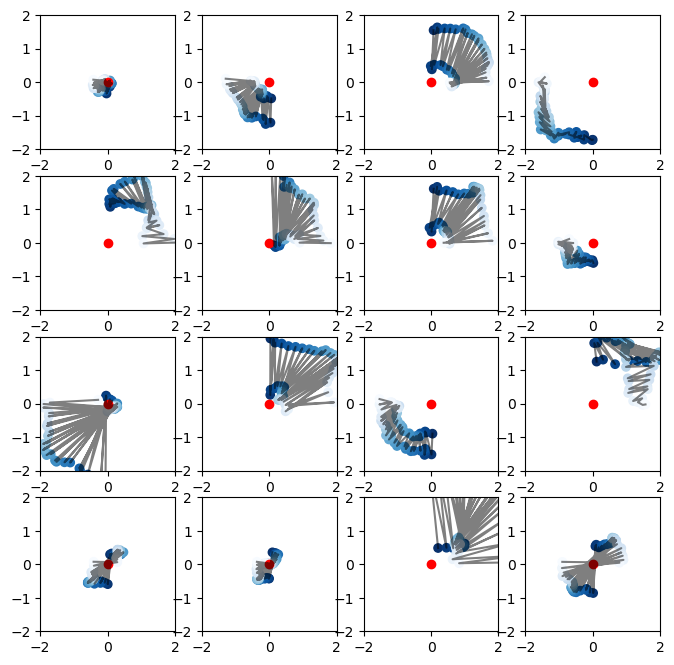


Epoch [1001/2000] -----------------------------------------------------------------------------
G: 16.24, Dr : 2.81, Df : 0.8


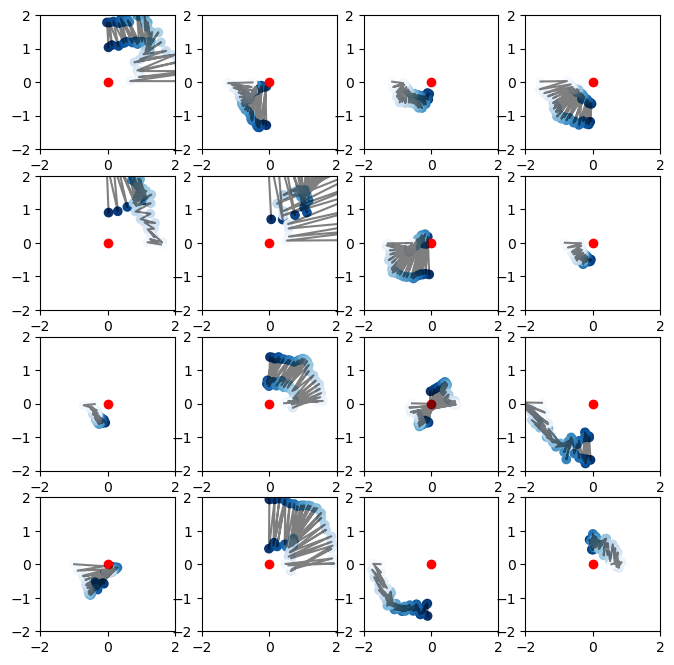


Epoch [1501/2000] -----------------------------------------------------------------------------
G: 14.43, Dr : 0.44, Df : 0.34


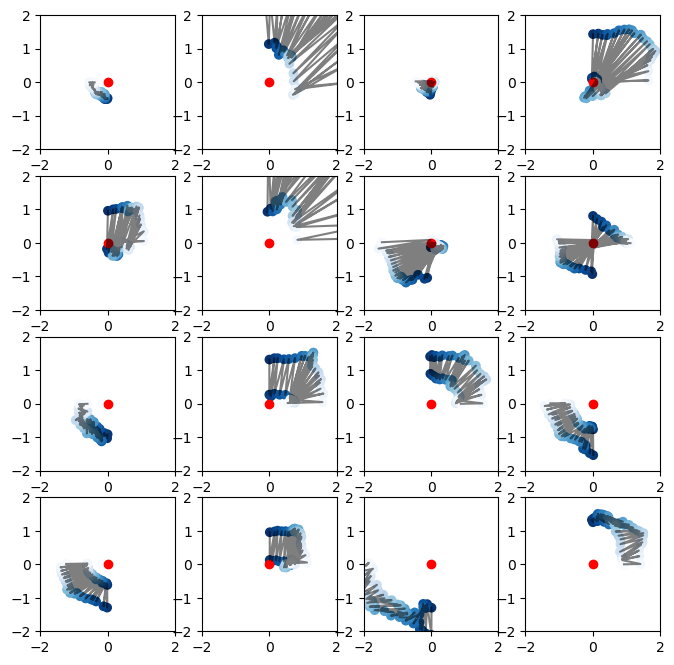


Epoch [2001/2000] -----------------------------------------------------------------------------
G: 14.38, Dr : 0.14, Df : 0.35


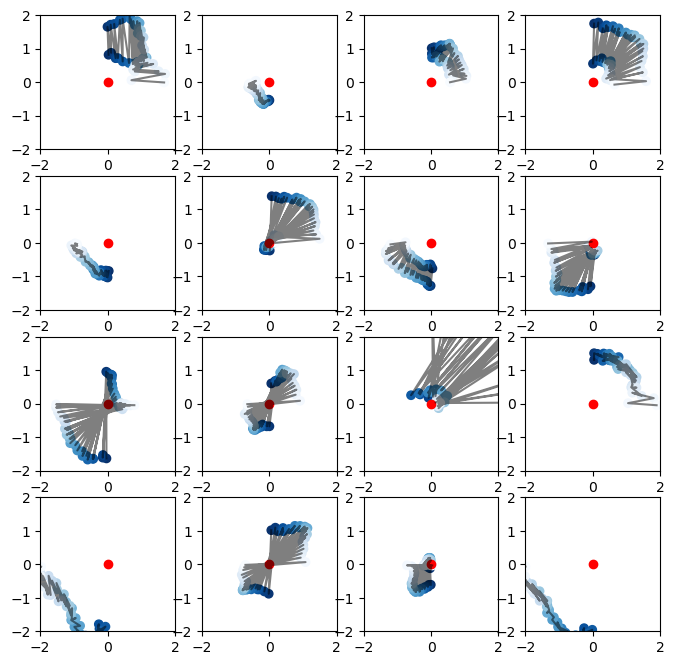

100% |########################################################################|


In [1559]:
# Train the model
nb_epoch = 2000
score = []

time_start = time.perf_counter()
epoch = 0
pbar = ProgressBar()
for i in pbar(range(nb_epoch)):
    epoch +=1
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for batch, x in enumerate(train_loader):
        
        #### TRAIN DISCRIMINATOR
        ## true samples
        x = x.to(device)
        batch_size = x.shape[0]

        target_ones = torch.ones((batch_size, 2), device=device)
        target_zeros = torch.zeros((batch_size, 2), device=device)

        discriminator.zero_grad()
        pred_real = discriminator(x)
        loss_real = criterion(pred_real, target_ones)

        ## false samples
        z = torch.randn((batch_size, 256, 1), device=device)
        with torch.no_grad():
            fake_samples = generator(z)
        pred_fake = discriminator(fake_samples)
        loss_fake = criterion(pred_fake, target_zeros)
        
        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        optim_d.step()

        loss_d_real_running += loss_real.item()
        loss_d_fake_running += loss_fake.item()

        #### TRAIN GENERATOR
        generator.zero_grad()
        z = torch.randn((batch_size, 256, 1), device=device)

        generated = generator(z)
        classifications = discriminator(generated)
        loss = criterion(classifications, target_ones) +  10*torch.mean((periodogram(generated) - periodogram(x))**2)
        loss.backward()
        optim_g.step()

        loss_g_running += loss.item()   

        score.append(torch.mean((periodogram(generated) - periodogram(x))**2))

    if epoch%500 == 0:
        print('\nEpoch [{}/{}] -----------------------------------------------------------------------------'
            .format(epoch+1, nb_epoch, i, len(train_loader)))
        print('G: {}, Dr : {}, Df : {}'
            .format(np.round(loss_g_running/batch_size, 2), np.round(loss_d_real_running/batch_size, 2), np.round(loss_d_fake_running/batch_size, 2)))
        
        nb = 16
        z = torch.randn((nb, 256, 1), device=device)
        with torch.no_grad():
          generated = generator(z)
        
        traj_sim = generated.cpu().detach().numpy()

        plt.figure(figsize = (8,8))

        for i in range(16):
          plt.subplot(4,4,i+1)
          plt.plot(traj_sim[i ,0,:], traj_sim[i ,1,:], c = 'black', alpha = 0.5)
          plt.scatter(traj_sim[i ,0,:], traj_sim[i ,1,:], c=np.arange(padding), cmap='Blues_r')
          plt.scatter(0,0, c = 'red')
          plt.xlim(-2,2)
          plt.ylim(-2,2)

        plt.show()
        plt.close()

In [1560]:
# with open('./results/score_SD_2.npy', 'wb') as f:
#     np.save(f, score)

torch.save(generator.state_dict(), 'results_amedeeGAN/G_SD_2.pt')
torch.save(discriminator.state_dict(), 'results_amedeeGAN/D_SD_2.pt')

# Results

### Amédée visualizations

In [1561]:
# generator = torch.load('./results/G_SD_1.pt')
nb = 100
traj_sim_1 = []
with torch.no_grad():
  for _ in range(nb):
    input_noise = torch.randn((1,256, 1), device=device)
    generated_output = generator(input_noise).reshape(num_nodes, 2)
    generated_output = generated_output - generated_output[0, :]
    generated_output = generated_output * std + mean

    traj_sim_1.append(generated_output)
  
# traj_sim_1 = generated.cpu().detach().numpy()
# print(traj_sim_1[0][:,1])
# print(df_list[0][1,:])
(x_1, lon_1, lat_1) = get_periodogram(traj_sim_1)
# data_fake_1 = format_simulation(traj_sim_1, colony, scale)

# data_fake_1 = data_fake_1[data_fake_1.dist_colony > 1000]

# generator = torch.load('./results/G_SD_2.pt')
# nb = 100
# z = torch.randn((100, 256, 1), device=device)
# with torch.no_grad():
#   generated = generator(z)
# traj_sim_2 = generated.cpu().detach().numpy()
# (x_2, lon_2, lat_2) = get_periodogram(traj_sim_2)
# data_fake_2 = format_simulation(traj_sim_2, colony, scale)
# data_fake_2 = data_fake_2[data_fake_2.dist_colony > 1000]

# generator = torch.load('./results/G_SD_3.pt')
# nb = 100
# z = torch.randn((100, 256, 1), device=device)
# with torch.no_grad():
#   generated = generator(z)
# traj_sim_3 = generated.cpu().detach().numpy()
# (x_3, lon_3, lat_3) = get_periodogram(traj_sim_3)
# data_fake_3 = format_simulation(traj_sim_3, colony, scale)
# data_fake_3 = data_fake_3[data_fake_3.dist_colony > 1000]

(x_real, lon_real, lat_real) = get_periodogram(df_list)

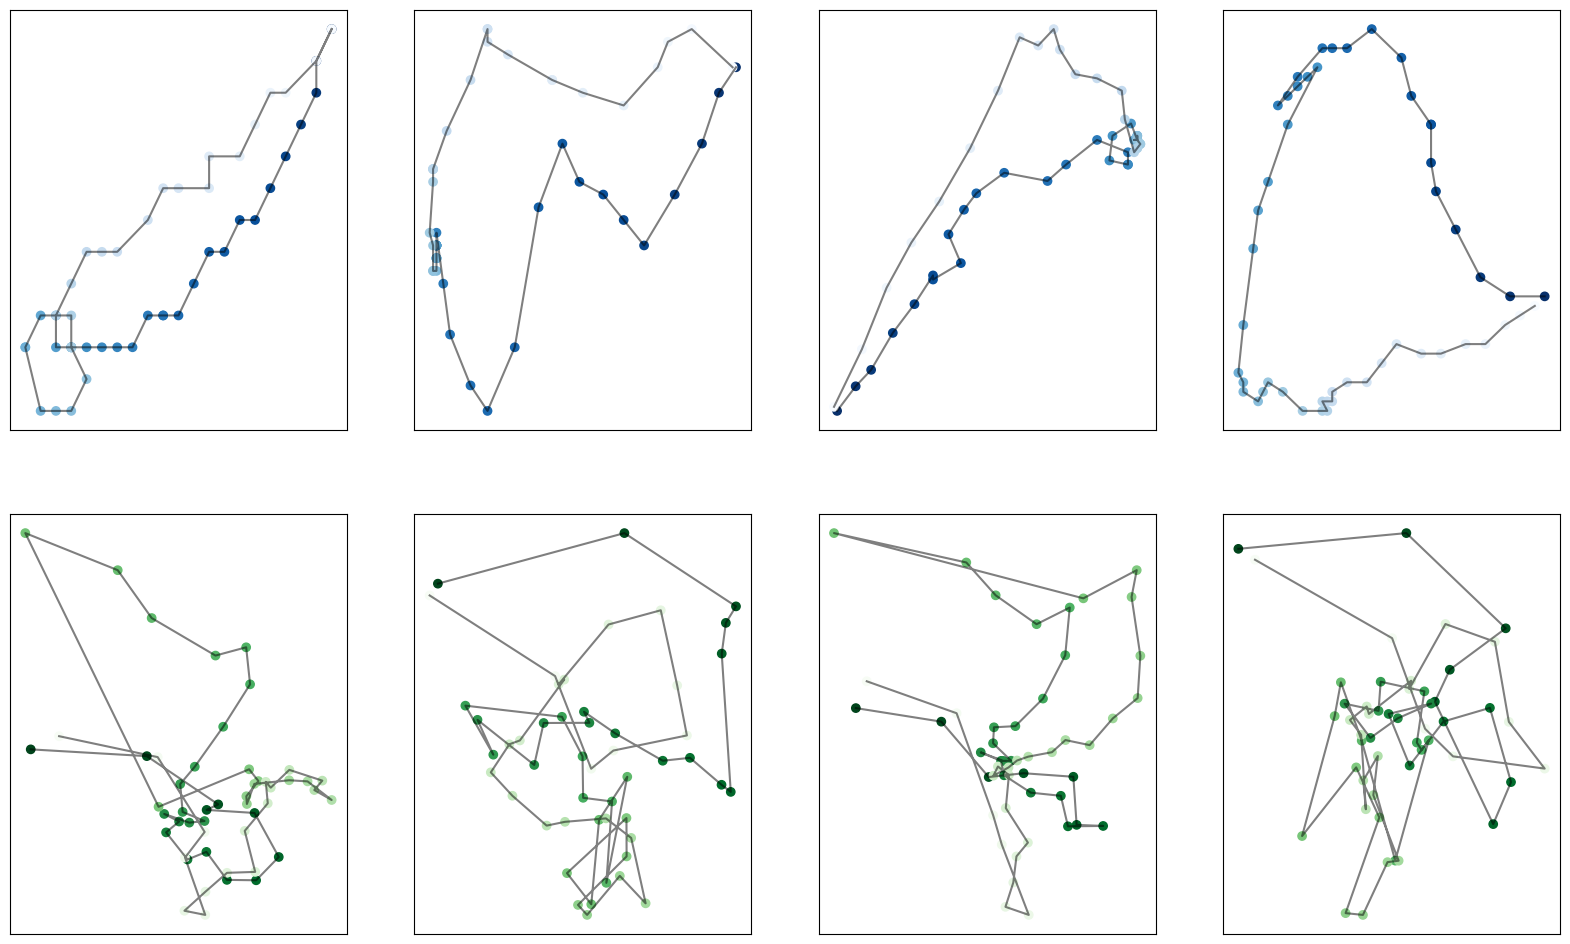

In [1562]:
nb = [1, 2, 3, 4]
k=1
plt.figure(figsize=(20,12))


for i in nb:
    plt.subplot(2,4,k)
    plt.plot(df_list[i][:,0], df_list[i][:,1], c = 'black', alpha = 0.5)
    plt.scatter(df_list[i][:,0], df_list[i][:,1], c=np.arange(len(df_list[0][:,0])), cmap='Blues_r')
    # plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    plt.ylabel('Real Data')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    k+=1


for i in nb:
    plt.subplot(2,4,k)
    plt.plot(traj_sim_1[i][:,0], traj_sim_1[i][:,1], c = 'black', alpha = 0.5)
    plt.scatter(traj_sim_1[i][:,0], traj_sim_1[i][:,1], c=np.arange(len(traj_sim_1[0][:,0])), cmap='Greens_r')
    # plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    plt.ylabel('GAN')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    k+=1

plt.show()

# for i in nb:
#     plt.subplot(3,4,k)
#     plt.plot(traj_sim_2[i,0,:], traj_sim_2[i,1,:], c = 'black', alpha = 0.5)
#     plt.scatter(traj_sim_2[i,0,:], traj_sim_2[i,1,:], c=np.arange(traj_sim_2.shape[2]), cmap='Oranges_r')
#     plt.scatter(0,0, c = 'red')
# #     plt.xlim(-1,1)
# #     plt.ylim(-1,1)
# #     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
#     plt.ylabel('GAN + Fourier')
#     ax = plt.gca()
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
#     k+=1
#     plt.show()


# for i in nb:
#     plt.subplot(4,4,k)
#     plt.plot(traj_sim_3[i,0,:], traj_sim_3[i,1,:], c = 'black', alpha = 0.5)
#     plt.scatter(traj_sim_3[i,0,:], traj_sim_3[i,1,:], c=np.arange(traj_sim_3.shape[2]), cmap='Greens_r')
#     plt.scatter(0,0, c = 'red')
# #     plt.xlim(-1,1)
# #     plt.ylim(-1,1)
# #     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
#     plt.ylabel('GAN + Fourier + step')
#     ax = plt.gca()
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
#     k+=1

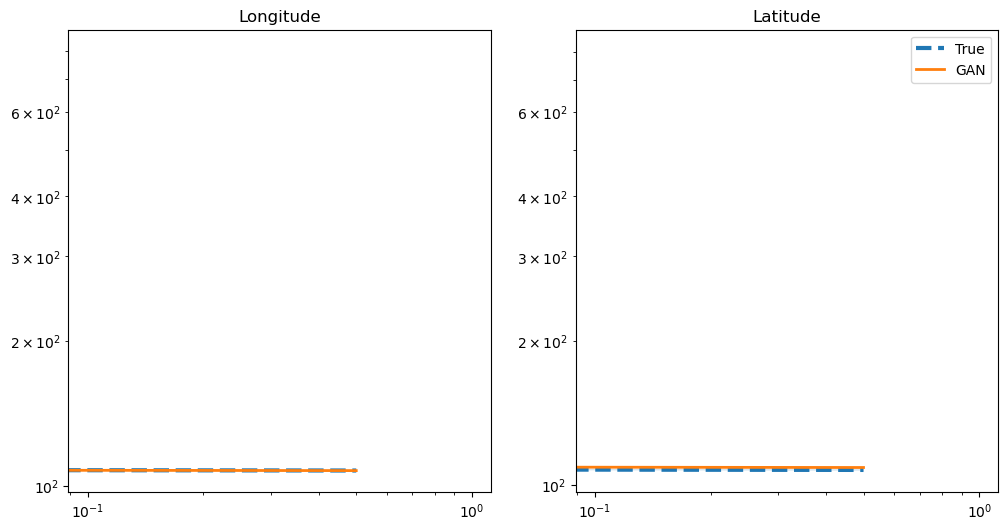

In [1563]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
plt.loglog(x_real, np.mean(lon_real, axis=0), linewidth = 3, linestyle = '--')
plt.fill_between(x_real, np.mean(lon_real, axis=0) - 0.5 * np.std(lon_real, axis=0) ,
                np.mean(lon_real, axis=0) + 0.5 * np.std(lon_real, axis=0),
                alpha = 0.2)


plt.loglog(x_real, np.mean(lon_1, axis=0), linewidth = 2)
# plt.loglog(x_real, np.mean(lon_2, axis=0), linewidth = 2)
# plt.loglog(x_real, np.mean(lon_3, axis=0), linewidth = 2)

plt.title('Longitude')

plt.subplot(1,2,2)
plt.loglog(x_real, np.mean(lat_real, axis=0), linewidth = 3, linestyle = '--', label = 'True')
plt.fill_between(x_real, np.mean(lat_real, axis=0) - 0.5 * np.std(lat_real, axis=0) ,
                np.mean(lat_real, axis=0) + 0.5 * np.std(lat_real, axis=0),
                alpha = 0.2)

plt.loglog(x_real, np.mean(lat_1, axis=0), linewidth = 2, label = 'GAN')
# plt.loglog(x_real, np.mean(lat_2, axis=0), linewidth = 2, label = 'GAN + fourier')
# plt.loglog(x_real, np.mean(lat_3, axis=0), linewidth = 2, label = 'GAN + fourier + step')


# plt.xlim([0, 0.5])
# plt.ylim([1e-6, 1e1])
plt.legend()
plt.title('Latitude')

plt.show()

### Other visualizations

In [1564]:
generator.eval()

num_graphs_to_generate = len(df_list)
generated_graphs = []
new_index = pd.RangeIndex(start=0, stop=new_size)


with torch.no_grad():  # Disable gradient calculation
    for _ in range(num_graphs_to_generate):
        input_noise = torch.randn((1,256, 1), device=device)
        generated_output = generator(input_noise).reshape(num_nodes, 2)
        generated_output = generated_output - generated_output[0, :]
        generated_output = generated_output * std + mean

        resized_df = pd.DataFrame(generated_output).reindex(new_index)
        resized_df = resized_df.interpolate(method='linear')  # Use linear interpolation
        generated_graphs.append(resized_df)
        # generated_graphs.append(pd.DataFrame(generated_output))

print(generated_graphs[0].shape)

(50, 2)


#### Individual trajectories

Trajectoires générées


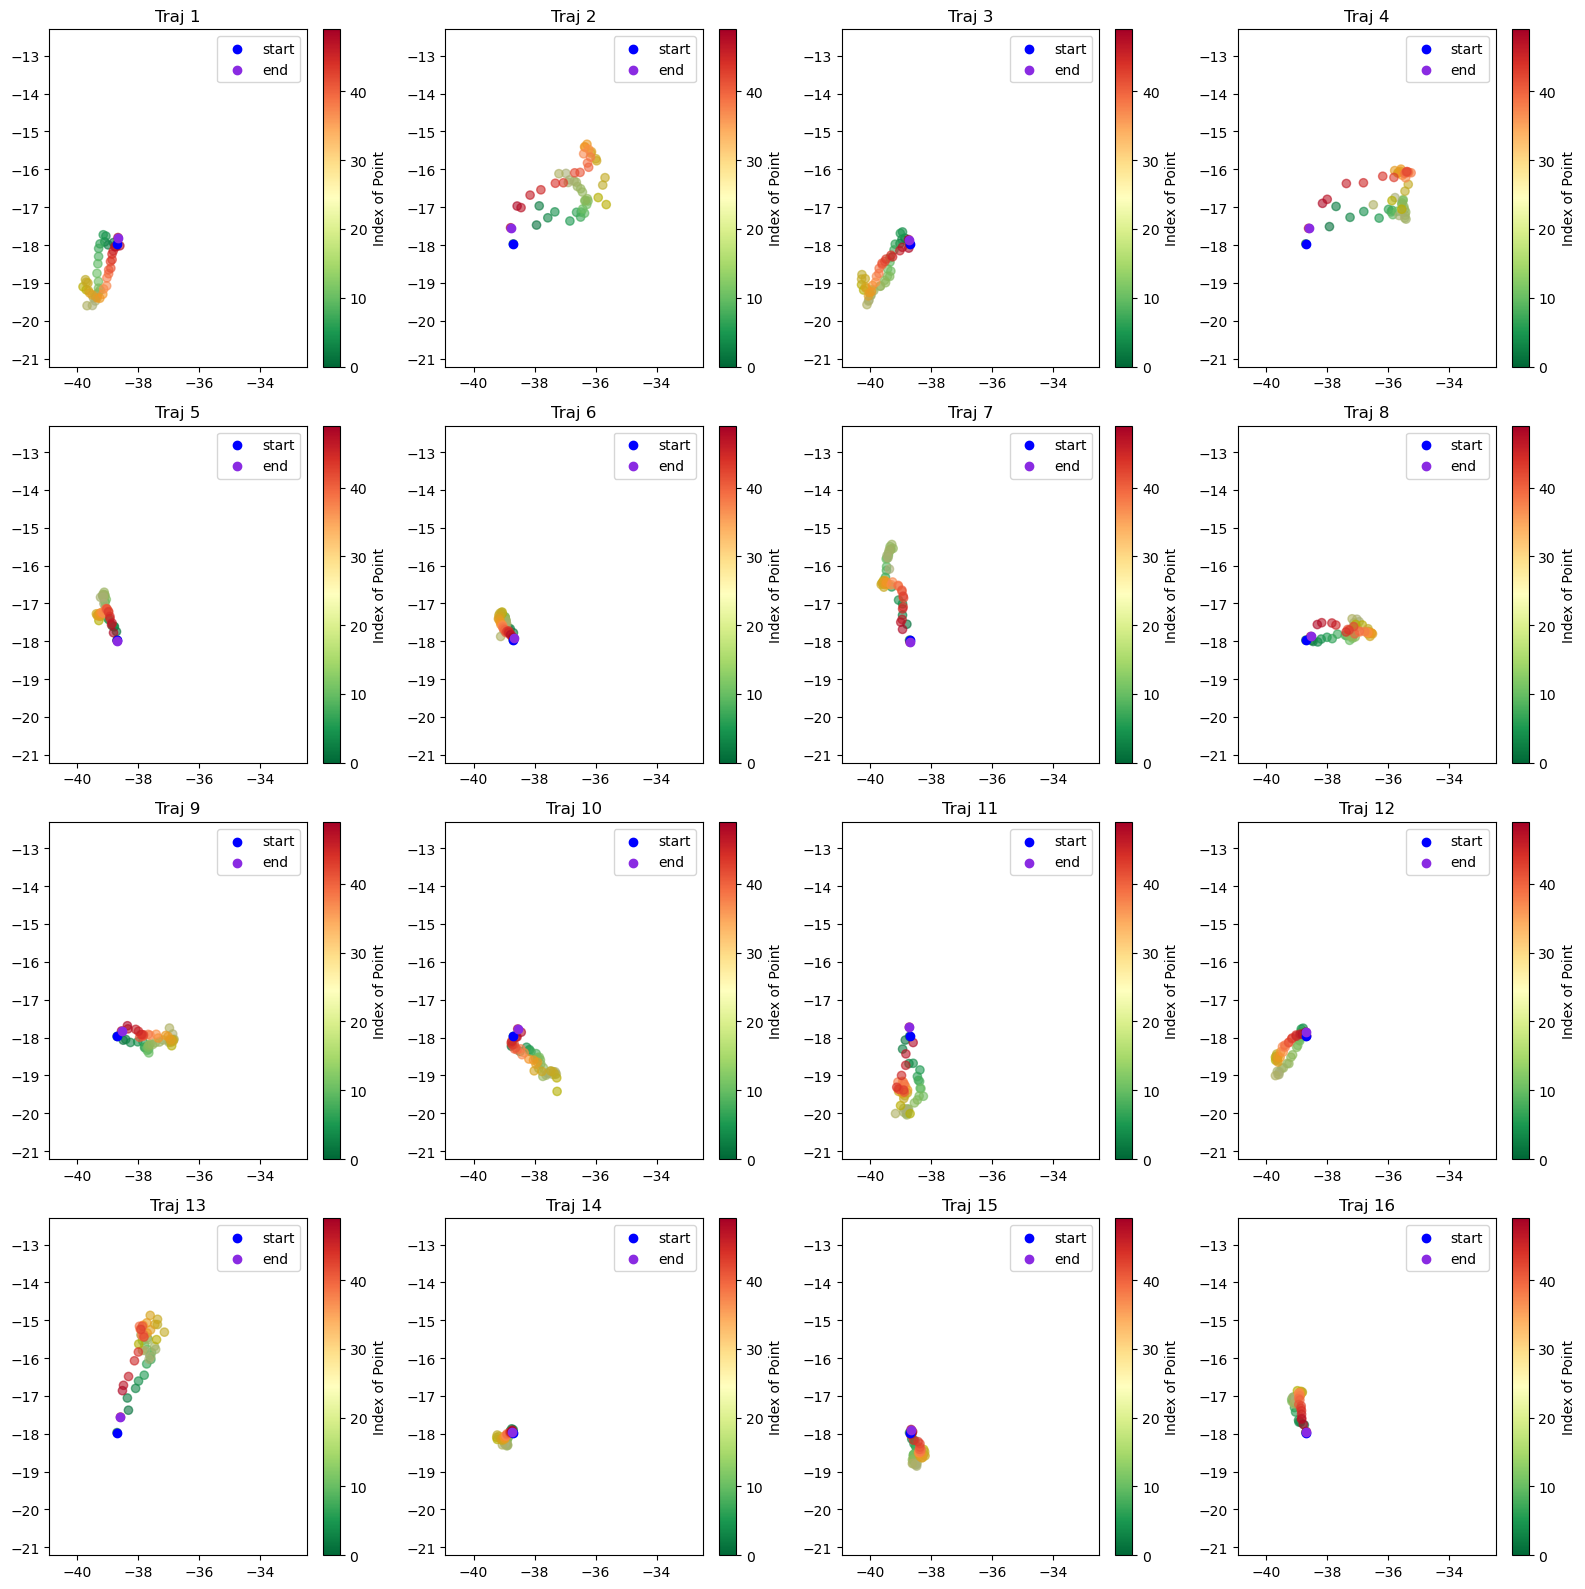

In [1565]:
nb = len(generated_graphs)
nb = 16
num_cols = 4
num_rows = int(np.ceil(nb / num_cols))

# Calculate the size of each subplot
subplot_size = 4
fig_width = num_cols * subplot_size
fig_height = num_rows * subplot_size

lon_arrays = [df[:][1] for df in generated_graphs]
lon_concatenated = np.concatenate(lon_arrays)
x_min = np.min(lon_concatenated)
x_max = np.max(lon_concatenated)

lat_arrays = [df[:][0] for df in generated_graphs]
lat_concatenated = np.concatenate(lat_arrays)
y_min = np.min(lat_concatenated)
y_max = np.max(lat_concatenated)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))


# indices = np.arange(len(resized_dfs[0]['lon']))
# norm = plt.Normalize(indices.min(), indices.max())
# cmap = plt.get_cmap('viridis')
# colors = cmap(norm(indices))

import hsluv
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

index = np.arange(new_size)
# cmap = plt.cm.get_cmap('RdYlGn_r')  # Red to green colormap
cmap = plt.colormaps['RdYlGn_r']
cmap.set_under('black')
colors = cmap(index / max(index))
hex_colors = [mcolors.to_hex(c) for c in colors]
hsluv_colors = [hsluv.hex_to_hsluv(c) for c in hex_colors]
colors = [hsluv.hsluv_to_hex((h, s, min(l, 70))) for h, s, l in hsluv_colors]

# Plot each trajectory
for i, ax in enumerate(axs.flatten()):
    if i < nb:
        x = generated_graphs[i][:][1]
        y = generated_graphs[i][:][0]

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # scatter = ax.scatter(x, y, c=indices, cmap='viridis', marker='o', alpha=0.6)
        scatter = ax.scatter(x, y, c=colors, marker='o', alpha=0.6)
        sm = ScalarMappable(cmap=cmap)
        sm.set_array(index)
        sm.set_clim(0, max(index))
        
        # Add start and end points
        ax.scatter(x[0], y[0], color='Blue', label='start')
        ax.scatter(x.iloc[-1], y.iloc[-1], color='BlueViolet', label='end')

        ax.set_title(f'Traj {i+1}')
        ax.legend(loc='best')
        
        # Add colorbar to each subplot
        plt.colorbar(sm, ax=ax, label='Index of Point')
    else:
        ax.axis('off')  # Hide empty subplots

print("Trajectoires générées")
plt.tight_layout()
plt.show()

In [1566]:
csv_files = glob.glob("../Data_segmented_completed_with_features_reshaped/*/"+str(new_size)+"nodes/"+oiseau+"*.csv")
main_path = gan+'/'+str(new_size)+"nodes/all_features/"+oiseau  # utilisé pour sauvegarder les modèles et les graphes générés


df_reals = []
for file in csv_files:
    df = pd.read_csv(file)
    df_reals.append(df)

columns = ["lat", "lon"]
# "dist_to_nest", "depth"
# dist_bool = True
df_reals = [np.array(df[columns]) for df in df_reals]
print(len(df_reals))

152


In [1567]:
import tools
importlib.reload(tools)         # pour recharger les modifications
from tools import *

generated_traj = [torch.tensor(generated_graphs[i][generated_graphs[i].columns].values) for i in range(len(generated_graphs))]


for i in range(len(generated_traj)) :
    generated_traj[i] = np.concatenate(( generated_traj[i], np.expand_dims(get_step_length(generated_traj[i]), axis=1) ), axis=1)
    generated_traj[i] = np.concatenate(( generated_traj[i], np.expand_dims(get_dist_nest(colony, generated_traj[i]), axis=1) ), axis=1)

print(len(df_reals))
print(len(generated_traj))
print(generated_traj[0].shape)

# df_reals = [df.to_numpy() for df in df_reals]
print(df_reals[0].shape)
for i in range(len(df_reals)):
    df_reals[i] = np.concatenate(( df_reals[i], np.expand_dims(get_step_length(df_reals[i]), axis=1) ), axis=1)
    df_reals[i] = np.concatenate(( df_reals[i], np.expand_dims(get_dist_nest(colony, df_reals[i]), axis=1) ), axis=1)

dist_max_gen = np.array([get_max_dist_nest(colony, generated_traj[i]) for i in range(len(generated_traj))])
total_dist_gen = np.array([total_distance(generated_traj[i]) for i in range(len(generated_traj))])
dist_max_real = np.array([get_max_dist_nest(colony, df_reals[i]) for i in range(len(df_reals))])
total_dist_real = np.array([total_distance(df_reals[i]) for i in range(len(df_reals))])

all_distances = dist_max_real + dist_max_gen
min_distance = min(min(dist_max_real), min(dist_max_gen))
max_distance = max(max(dist_max_real), max(dist_max_gen))
all_total = total_dist_real + total_dist_gen
min_total = min(min(total_dist_real), min(total_dist_gen))
max_total = max(max(total_dist_real), max(total_dist_gen))


# # Plot for single trajectories
# for i in range(min(3, len(generated_traj))) :

#     dist_nest_column = torch.tensor(get_dist_nest(colony, generated_traj[i]))
#     plt.plot(dist_nest_column)
#     plt.title("Distance to nest for graph "+str(i))
#     plt.show()
#     # print(dist_nest_column)
#     # plt.scatter(generated_traj[i][:,0], generated_traj[i][:,1])
#     # plt.title("Graph "+str(i))
#     # plt.show()

#     step_length_column = torch.tensor(get_step_length(generated_traj[i]))
#     plt.plot(step_length_column)
#     plt.title("Step length for graph "+str(i))
#     plt.show()


152
152
(50, 4)
(50, 2)


#### Descriptive stats

[0.         2.38964782 5.632902   7.79186222 1.11312317 2.38898487
 1.11312317 0.86640247 0.         1.11312317 0.         0.
 0.         3.44985704 4.77726179 1.11312317 2.81963266 1.4097038
 1.72987381 3.63417172 3.45925838 3.45925838 3.41894943 3.41950621
 2.05778225 0.86542585 0.         0.         0.         0.
 1.11312317 3.44976511 2.82068239 3.42200956 3.44997957 4.5361218
 4.53621493 3.33936952 4.53637785 0.         5.56561587 2.38942694
 3.42561929 1.41157651 2.38955948 3.64763719 0.         0.86847218
 0.86847218 7.89565352]


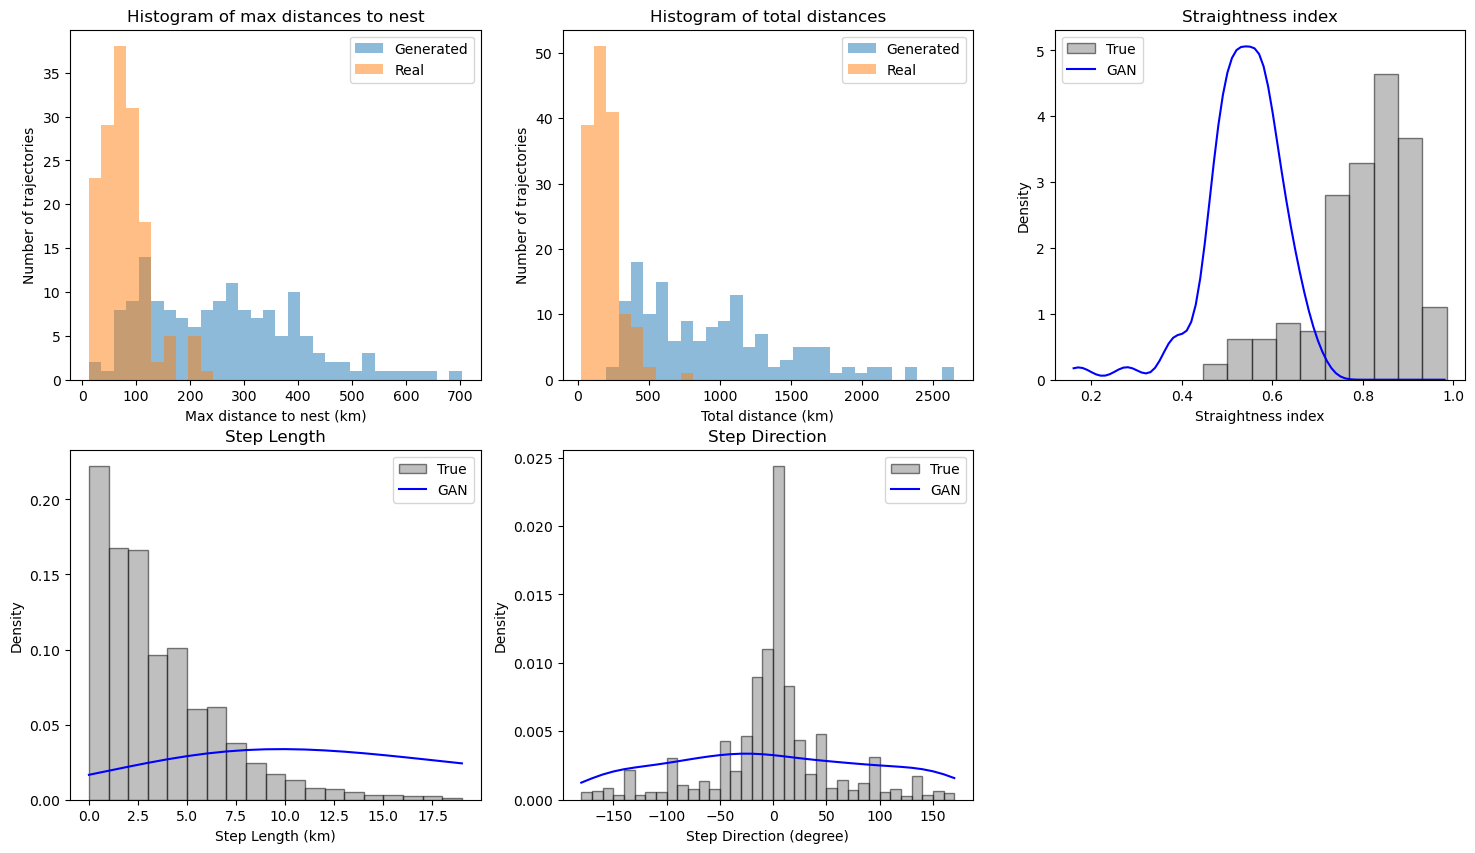

In [1568]:
plt.figure(figsize=(18, 10))


# print histogramme des distances max des générées et des réelles
plt.subplot(2, 3, 1)
plt.hist(dist_max_gen, bins=30, alpha=0.5, label='Generated', range=(min_distance, max_distance))
plt.hist(dist_max_real, bins=30, alpha=0.5, label='Real', range=(min_distance, max_distance))
plt.legend(loc='upper right')
plt.xlabel("Max distance to nest (km)")
plt.ylabel("Number of trajectories")
plt.title("Histogram of max distances to nest")

# print histogramme des distances totales des générées et des réelles
plt.subplot(2, 3, 2)
plt.hist(total_dist_gen, bins=30, alpha=0.5, label='Generated', range=(min_total, max_total))
plt.hist(total_dist_real, bins=30, alpha=0.5, label='Real', range=(min_total, max_total))
plt.legend(loc='upper right')
plt.xlabel("Total distance (km)")
plt.ylabel("Number of trajectories")
plt.title("Histogram of total distances")


# STRAIGHTNESS INDEX
plt.subplot(2, 3, 3)
# Plus la valeur est proche de 1, plus le trajet est rectiligne
y = [get_trip_sinuosity(df) for df in df_reals]
y_1 = [get_trip_sinuosity(traj) for traj in generated_traj]
# y_3 = get_trip_sinuosity(data_fake_3)
dy_1 = kde1d(y_1, bw = 0.3)
# dy_3 = kde1d(y_3, bw = 0.3)

x = np.arange(min(min(y),min(y_1)), max(max(y),max(y_1)), 0.01)
plt.hist(y, color = 'gray', label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_1(x), color = 'blue', label = 'GAN')
# plt.plot(x, dy_3(x), color = dicolour['green'], label = 'GAN + Fourier+ step')
plt.xlabel('Straightness index')
plt.ylabel('Density')
plt.title('Straightness index')
plt.legend()


# STEP LENGTH
plt.subplot(2, 3, 4)
y_1 = np.concatenate([traj[:,2] for traj in generated_traj])
# y_3 = data_fake_3.step_distance/1e3
dy_1 = kde1d(y_1, bw = 0.3)
# dy_3 = kde1d(y_3.dropna(), bw = 0.3)
print(df_reals[0][:,2])

x = np.arange(0,20, 1)
plt.hist(np.concatenate([df[:,2] for df in df_reals]), color = 'gray', label = 'True', alpha = 0.5, edgecolor='k', density = True, bins = x)
plt.plot(x, dy_1(x), color = 'blue', label = 'GAN')
# plt.plot(x, dy_3(x), color = dicolour['green'], label = 'GAN + Fourier+ step')
plt.ylabel('Density')
plt.xlabel('Step Length (km)')
plt.title('Step Length')
plt.legend()


# STEP DIRECTION
plt.subplot(2, 3, 5)
c_fake = np.concatenate( [cap( traj[0:(new_size-1), 1], traj[0:(new_size-1), 0], traj[1:, 1], traj[1:, 0]) for traj in generated_traj] )
direction_fake = [d%360 - 360 if d%360 > 180 else d%360 for d in np.diff(c_fake)]

c_real = np.concatenate( [cap( df[0:(new_size-1), 1], df[0:(new_size-1), 0], df[1:, 1], df[1:, 0]) for df in df_reals] )
direction_real = [d%360 - 360 if d%360 > 180 else d%360 for d in np.diff(c_real)]

y_1 = direction_fake
# y_3 = data_fake_3.step_direction
dy_1 = kde1d(y_1, bw = 0.3)
# dy_3 = kde1d(y_3.dropna(), bw = 0.3)

x = np.arange(-180,180, 10)
plt.hist(direction_real, bins = x, color = 'gray', label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_1(x), color = 'blue', label = 'GAN')
# plt.plot(x, dy_3(x), color = dicolour['green'], label = 'GAN + Fourier+ step')
plt.ylabel('Density')
plt.xlabel('Step Direction (degree)')
plt.title('Step Direction')
plt.legend()


#### On a map

In [1569]:
import graph_visualisation
importlib.reload(graph_visualisation)         # pour recharger les modifications
from graph_visualisation import *

df_generated = [pd.DataFrame(generated_traj[i][:,:2], columns=columns) for i in range(len(generated_traj))]

for i in range(len(df_generated)):
    df_generated[i].iloc[:, :] = df_generated[i].iloc[:, :] - df_generated[i].iloc[0, :]
    df_generated[i] = df_generated[i]*std + mean

# colony = df_generated[0][["lat","lon"]].iloc[0]
# colony_abr= [-17.97, -38.70]

print("Generated trajectories:")
plot_map(df_generated, colony)
print("Real trajectories:")
df_list_columns = [pd.DataFrame(df_list[i][:,:2], columns=columns) for i in range(len(df_list))]
plot_map(df_list_columns, colony)

Generated trajectories:


Real trajectories:
